# Nonlinear tracking experiment using numpy and TensorFlow

Author: Simo Särkkä

This demo is about solving the optimal control problem of a non-linear robot or car which
is moving on a track.

The first part of the experiment is written in pure numpy, but the second part needs TensorFlow.

## Imports

In [1]:
import numpy as np
import parallel_control.nlqt_np as nlqt_np
import parallel_control.nonlinear_model_np as nonlinear_model_np
import matplotlib.pyplot as plt

## Simulate data and and plot it


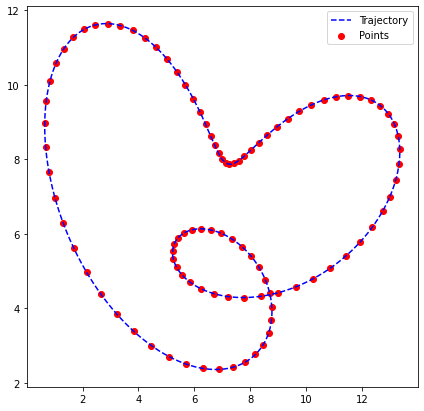

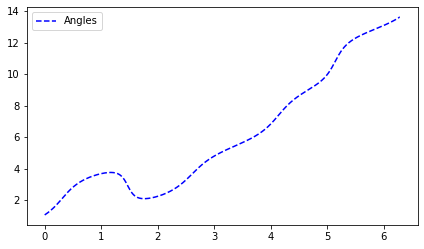

In [2]:
N = 1000
model = nonlinear_model_np.NonlinearModel()
xyt, xyt_dense = model.genData(N)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(xyt_dense[0,:], xyt_dense[1,:], label="Trajectory", color="b", linestyle="--")
ax.scatter(xyt[0,:], xyt[1,:], label="Points", color="r")
_ = plt.legend()


fig, ax = plt.subplots(figsize=(7, 4))
tt = np.linspace(0,2 * np.pi, N)
ax.plot(tt, xyt_dense[2,:], label="Angles", color="b", linestyle="--")
_ = plt.legend()


## Create the LQT and form the initial guess (= zeros)

In [3]:
lqt, x0 = model.getLQT(xyt)
nlqt = nlqt_np.NLQT(lqt, model)
u, x = model.initialGuess(lqt, x0, init_to_zero=True)

## Iterate the LQT
You can run this multiple times if it doesn't appear to have yet converged

iter 1/10 cost = 2000652.242839
iter 2/10 cost = 1595.943493
iter 3/10 cost = 1576.602077
iter 4/10 cost = 1576.597290
iter 5/10 cost = 1576.597290
iter 6/10 cost = 1576.597290
iter 7/10 cost = 1576.597290
iter 8/10 cost = 1576.597290
iter 9/10 cost = 1576.597290
iter 10/10 cost = 1576.597290


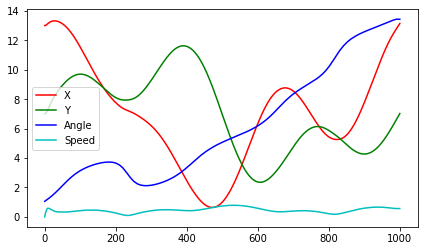

In [4]:
cost0 = nlqt.cost(x[0], u)
cost = cost0
niter = 10
for i in range(niter):
    u, x = nlqt.iterate(u, x)
    cost = nlqt.cost(x[0], u)
    print("iter %d/%d cost = %f" % (i+1,niter,cost))

u_np = u
x_np = x

fig, ax = plt.subplots(figsize=(7, 4))
tt = np.arange(len(x))
xx = np.array(x)
ax.plot(tt, xx[:,0], label="X", color="r", linestyle="-")
ax.plot(tt, xx[:,1], label="Y", color="g", linestyle="-")
ax.plot(tt, xx[:,2], label="Angle", color="b", linestyle="-")
ax.plot(tt, xx[:,3], label="Speed", color="c", linestyle="-")
_ = plt.legend()


## Check what the controlled trajectory looks like

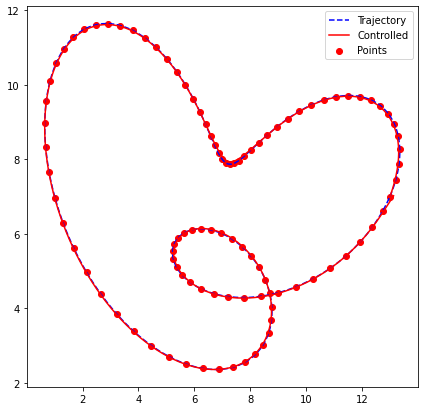

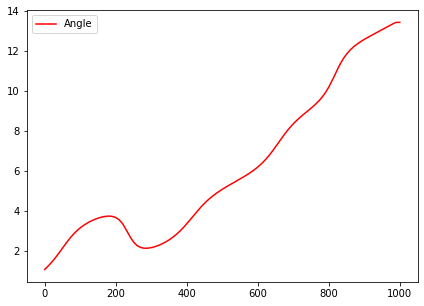

In [5]:
xp = nlqt.simulate(x0, u)
xp_np = np.array(xp)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(xyt_dense[0,:], xyt_dense[1,:], label="Trajectory", color="b", linestyle="--")
ax.plot(xp_np[:,0], xp_np[:,1], label="Controlled", color="r", linestyle="-")
ax.scatter(xyt[0,:], xyt[1,:], label="Points", color="r")
_ = plt.legend()

np.savetxt('res/nlqt_xyt_dense.txt', xyt_dense)
np.savetxt('res/nlqt_xp_np.txt', xp_np)
np.savetxt('res/nlqt_xyt.txt', xyt)

fig, ax = plt.subplots(figsize=(7, 5))
tt = np.arange(len(xp))
ax.plot(tt, xp_np[:,2], label="Angle", color="r", linestyle="-")
_ = plt.legend()

## Show the control signals

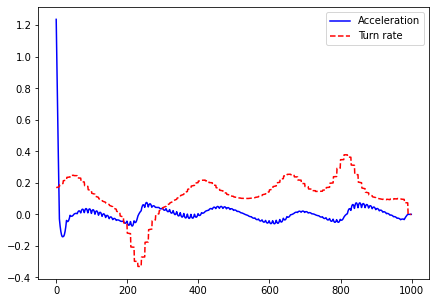

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
tt = np.arange(len(u))
uu = np.array(u)
ax.plot(tt, uu[:,0], label="Acceleration", color="b", linestyle="-")
ax.plot(tt, uu[:,1], label="Turn rate", color="r", linestyle="--")
_ = plt.legend()

---

## Imports for the TensorFlow version

In [7]:
import tensorflow as tf
import parallel_control.lqt_tf as lqt_tf
import parallel_control.nlqt_tf as nlqt_tf
import parallel_control.nonlinear_model_tf as nonlinear_model_tf

## Run the nonlinear tests above with TensorFlow


In [ ]:
N = 1000
model = nonlinear_model_np.NonlinearModel()
xyt, xyt_dense = model.genData(N)

lqt, x0 = model.getLQT(xyt)
nlqt = nlqt_np.NLQT(lqt, model)
u, x = model.initialGuess(lqt, x0, init_to_zero=True)

us = tf.convert_to_tensor(u)
xs = tf.convert_to_tensor(x)
Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us = lqt_tf.lqt_np_to_tf(nlqt.lqt)

f  = nonlinear_model_tf.nonlinear_model_f
Fx = nonlinear_model_tf.nonlinear_model_Fx
Fu = nonlinear_model_tf.nonlinear_model_Fu

cost0 = nlqt_tf.nlqt_cost(xs[0,...], us, f, Hs, HT, rs, rT, Xs, XT, Us)
cost = cost0
niter = 10
for i in range(niter):
#    us, xs = nlqt_tf.nlqt_iterate_seq(us, xs, f, Fx, Fu, Hs, HT, rs, rT, Xs, XT, Us)
#    us, xs = nlqt_tf.nlqt_iterate_par_1(us, xs, f, Fx, Fu, Hs, HT, rs, rT, Xs, XT, Us)
    us, xs = nlqt_tf.nlqt_iterate_par_2(us, xs, f, Fx, Fu, Hs, HT, rs, rT, Xs, XT, Us)
    cost = nlqt_tf.nlqt_cost(xs[0,...], us, f, Hs, HT, rs, rT, Xs, XT, Us)
    print("iter %d/%d cost = %f" % (i+1,niter,cost))

us_tf = us
xs_tf = xs

print('x-diff = %f' % tf.reduce_max(tf.abs(tf.convert_to_tensor(x_np, dtype=xs_tf.dtype) - xs_tf)))
print('u-diff = %f' % tf.reduce_max(tf.abs(tf.convert_to_tensor(u_np, dtype=us_tf.dtype) - us_tf)))